In [3]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [4]:
def get_data():
    #get train data
    train_data_path ='train.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='test.csv'
    test = pd.read_csv(test_data_path)
    
    return train , test

def get_combined_data():
  #reading train data
  train , test = get_data()

  target = train.SalePrice
  train.drop(['SalePrice'],axis = 1 , inplace = True)

  combined = train.append(test)
  combined.reset_index(inplace=True)
  combined.drop(['index', 'Id'], inplace=True, axis=1)
  return combined, target

In [5]:
#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [6]:
combined.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [7]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [8]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [9]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


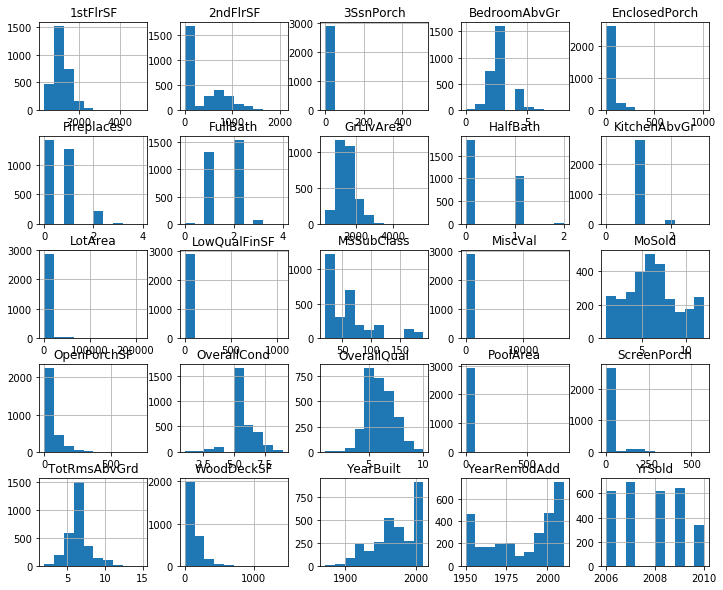

In [10]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

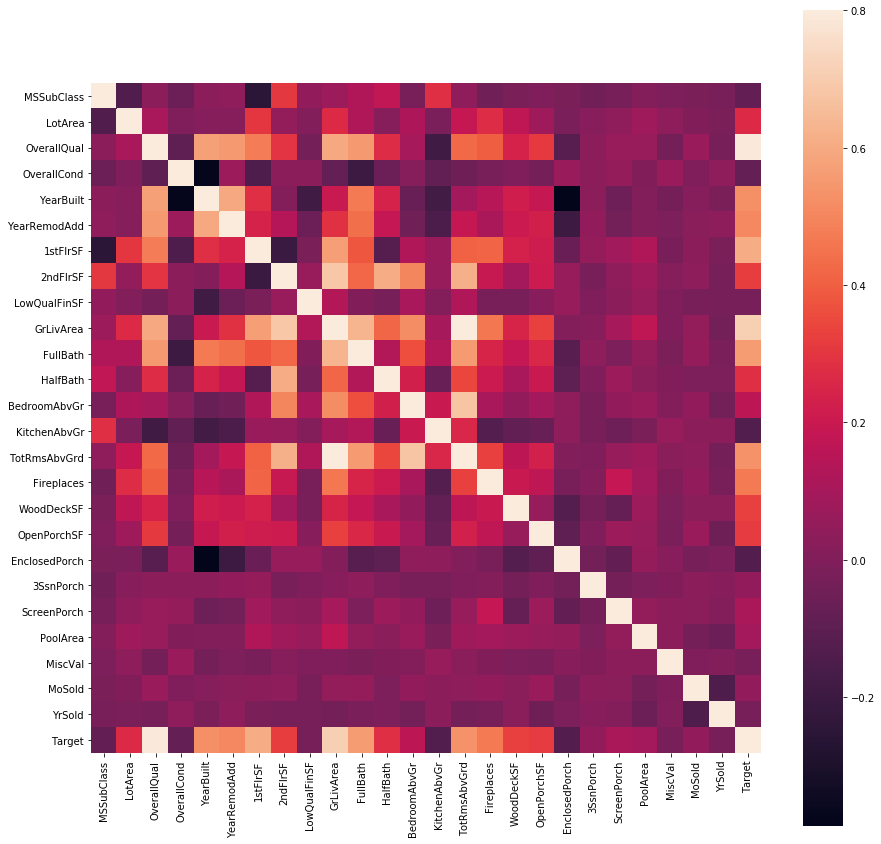

In [11]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [12]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

In [13]:
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 45 columns before encoding categorical features
There are 149 columns after encoding categorical features


In [15]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 
  
train, test = split_combined()

In [16]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               19200     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 184,065
Trainable params: 184,065
Non-trainable params: 0
_________________________________________________________________


In [17]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [18]:
NN_model.fit(train, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)




Train on 1168 samples, validate on 292 samples
Epoch 1/500
1168/1168 [==============================] - 1s 437us/step - loss: 138574.9681 - mean_absolute_error: 138574.9681 - val_loss: 57688.0966 - val_mean_absolute_error: 57688.0966

Epoch 00001: val_loss improved from inf to 57688.09664, saving model to Weights-001--57688.09664.hdf5
Epoch 2/500
1168/1168 [==============================] - 0s 84us/step - loss: 55377.1110 - mean_absolute_error: 55377.1110 - val_loss: 48314.9666 - val_mean_absolute_error: 48314.9666

Epoch 00002: val_loss improved from 57688.09664 to 48314.96661, saving model to Weights-002--48314.96661.hdf5
Epoch 3/500
1168/1168 [==============================] - 0s 71us/step - loss: 47622.8976 - mean_absolute_error: 47622.8976 - val_loss: 48008.2392 - val_mean_absolute_error: 48008.2392

Epoch 00003: val_loss improved from 48314.96661 to 48008.23924, saving model to Weights-003--48008.23924.hdf5
Epoch 4/500
1168/1168 [==============================] - 0s 85us/step -

1168/1168 [==============================] - 0s 87us/step - loss: 31309.2565 - mean_absolute_error: 31309.2565 - val_loss: 34207.4456 - val_mean_absolute_error: 34207.4456

Epoch 00029: val_loss did not improve from 34008.91192
Epoch 30/500
1168/1168 [==============================] - 0s 77us/step - loss: 30702.4020 - mean_absolute_error: 30702.4020 - val_loss: 35484.7459 - val_mean_absolute_error: 35484.7459

Epoch 00030: val_loss did not improve from 34008.91192
Epoch 31/500
1168/1168 [==============================] - 0s 67us/step - loss: 30817.7776 - mean_absolute_error: 30817.7776 - val_loss: 34632.9875 - val_mean_absolute_error: 34632.9875

Epoch 00031: val_loss did not improve from 34008.91192
Epoch 32/500
1168/1168 [==============================] - 0s 69us/step - loss: 30970.5776 - mean_absolute_error: 30970.5776 - val_loss: 35131.1425 - val_mean_absolute_error: 35131.1425

Epoch 00032: val_loss did not improve from 34008.91192
Epoch 33/500
1168/1168 [=========================

1168/1168 [==============================] - 0s 73us/step - loss: 30251.7639 - mean_absolute_error: 30251.7639 - val_loss: 32157.8089 - val_mean_absolute_error: 32157.8089

Epoch 00061: val_loss did not improve from 31597.22522
Epoch 62/500
1168/1168 [==============================] - 0s 72us/step - loss: 28164.9173 - mean_absolute_error: 28164.9173 - val_loss: 32744.7915 - val_mean_absolute_error: 32744.7915

Epoch 00062: val_loss did not improve from 31597.22522
Epoch 63/500
1168/1168 [==============================] - 0s 68us/step - loss: 28526.5706 - mean_absolute_error: 28526.5706 - val_loss: 35770.8274 - val_mean_absolute_error: 35770.8274

Epoch 00063: val_loss did not improve from 31597.22522
Epoch 64/500
1168/1168 [==============================] - 0s 80us/step - loss: 28855.1864 - mean_absolute_error: 28855.1864 - val_loss: 35479.9653 - val_mean_absolute_error: 35479.9653

Epoch 00064: val_loss did not improve from 31597.22522
Epoch 65/500
1168/1168 [=========================


Epoch 00092: val_loss improved from 27598.06550 to 27492.71190, saving model to Weights-092--27492.71190.hdf5
Epoch 93/500
1168/1168 [==============================] - 0s 78us/step - loss: 23895.8016 - mean_absolute_error: 23895.8016 - val_loss: 27025.7414 - val_mean_absolute_error: 27025.7414

Epoch 00093: val_loss improved from 27492.71190 to 27025.74138, saving model to Weights-093--27025.74138.hdf5
Epoch 94/500
1168/1168 [==============================] - 0s 71us/step - loss: 23537.9482 - mean_absolute_error: 23537.9482 - val_loss: 26303.1295 - val_mean_absolute_error: 26303.1295

Epoch 00094: val_loss improved from 27025.74138 to 26303.12955, saving model to Weights-094--26303.12955.hdf5
Epoch 95/500
1168/1168 [==============================] - 0s 66us/step - loss: 23329.7850 - mean_absolute_error: 23329.7850 - val_loss: 28024.0850 - val_mean_absolute_error: 28024.0850

Epoch 00095: val_loss did not improve from 26303.12955
Epoch 96/500
1168/1168 [==============================] 


Epoch 00124: val_loss did not improve from 23567.13656
Epoch 125/500
1168/1168 [==============================] - 0s 105us/step - loss: 21422.0208 - mean_absolute_error: 21422.0208 - val_loss: 30148.0665 - val_mean_absolute_error: 30148.0665

Epoch 00125: val_loss did not improve from 23567.13656
Epoch 126/500
1168/1168 [==============================] - 0s 68us/step - loss: 20570.9361 - mean_absolute_error: 20570.9361 - val_loss: 25734.5230 - val_mean_absolute_error: 25734.5230

Epoch 00126: val_loss did not improve from 23567.13656
Epoch 127/500
1168/1168 [==============================] - 0s 67us/step - loss: 21354.4078 - mean_absolute_error: 21354.4078 - val_loss: 24946.8595 - val_mean_absolute_error: 24946.8595

Epoch 00127: val_loss did not improve from 23567.13656
Epoch 128/500
1168/1168 [==============================] - 0s 79us/step - loss: 20775.6488 - mean_absolute_error: 20775.6488 - val_loss: 24282.5931 - val_mean_absolute_error: 24282.5931

Epoch 00128: val_loss did not 


Epoch 00157: val_loss did not improve from 22664.02975
Epoch 158/500
1168/1168 [==============================] - 0s 79us/step - loss: 19534.0646 - mean_absolute_error: 19534.0646 - val_loss: 25983.2868 - val_mean_absolute_error: 25983.2868

Epoch 00158: val_loss did not improve from 22664.02975
Epoch 159/500
1168/1168 [==============================] - 0s 91us/step - loss: 18820.5996 - mean_absolute_error: 18820.5996 - val_loss: 24380.8371 - val_mean_absolute_error: 24380.8371

Epoch 00159: val_loss did not improve from 22664.02975
Epoch 160/500
1168/1168 [==============================] - 0s 83us/step - loss: 18719.7260 - mean_absolute_error: 18719.7260 - val_loss: 22577.6001 - val_mean_absolute_error: 22577.6001

Epoch 00160: val_loss improved from 22664.02975 to 22577.60012, saving model to Weights-160--22577.60012.hdf5
Epoch 161/500
1168/1168 [==============================] - 0s 74us/step - loss: 18577.5379 - mean_absolute_error: 18577.5379 - val_loss: 22369.4628 - val_mean_abso

1168/1168 [==============================] - 0s 77us/step - loss: 18574.8561 - mean_absolute_error: 18574.8561 - val_loss: 23281.5423 - val_mean_absolute_error: 23281.5423

Epoch 00190: val_loss did not improve from 21830.41417
Epoch 191/500
1168/1168 [==============================] - 0s 76us/step - loss: 17129.5912 - mean_absolute_error: 17129.5912 - val_loss: 23336.4128 - val_mean_absolute_error: 23336.4128

Epoch 00191: val_loss did not improve from 21830.41417
Epoch 192/500
1168/1168 [==============================] - 0s 89us/step - loss: 17860.0350 - mean_absolute_error: 17860.0350 - val_loss: 22145.2630 - val_mean_absolute_error: 22145.2630

Epoch 00192: val_loss did not improve from 21830.41417
Epoch 193/500
1168/1168 [==============================] - 0s 77us/step - loss: 18531.6708 - mean_absolute_error: 18531.6708 - val_loss: 26683.1598 - val_mean_absolute_error: 26683.1598

Epoch 00193: val_loss did not improve from 21830.41417
Epoch 194/500
1168/1168 [=====================

1168/1168 [==============================] - 0s 84us/step - loss: 17320.0479 - mean_absolute_error: 17320.0479 - val_loss: 21611.1094 - val_mean_absolute_error: 21611.1094

Epoch 00223: val_loss did not improve from 21422.42621
Epoch 224/500
1168/1168 [==============================] - 0s 90us/step - loss: 16535.9196 - mean_absolute_error: 16535.9196 - val_loss: 21811.1873 - val_mean_absolute_error: 21811.1873

Epoch 00224: val_loss did not improve from 21422.42621
Epoch 225/500
1168/1168 [==============================] - 0s 91us/step - loss: 17555.5350 - mean_absolute_error: 17555.5350 - val_loss: 24119.3978 - val_mean_absolute_error: 24119.3978

Epoch 00225: val_loss did not improve from 21422.42621
Epoch 226/500
1168/1168 [==============================] - 0s 79us/step - loss: 17492.8304 - mean_absolute_error: 17492.8304 - val_loss: 23765.4963 - val_mean_absolute_error: 23765.4963

Epoch 00226: val_loss did not improve from 21422.42621
Epoch 227/500
1168/1168 [=====================


Epoch 00256: val_loss did not improve from 20821.16840
Epoch 257/500
1168/1168 [==============================] - 0s 75us/step - loss: 16611.8178 - mean_absolute_error: 16611.8178 - val_loss: 23016.8684 - val_mean_absolute_error: 23016.8684

Epoch 00257: val_loss did not improve from 20821.16840
Epoch 258/500
1168/1168 [==============================] - 0s 78us/step - loss: 17608.8541 - mean_absolute_error: 17608.8541 - val_loss: 25719.9326 - val_mean_absolute_error: 25719.9326

Epoch 00258: val_loss did not improve from 20821.16840
Epoch 259/500
1168/1168 [==============================] - 0s 79us/step - loss: 16168.4978 - mean_absolute_error: 16168.4978 - val_loss: 24165.8083 - val_mean_absolute_error: 24165.8083

Epoch 00259: val_loss did not improve from 20821.16840
Epoch 260/500
1168/1168 [==============================] - 0s 76us/step - loss: 17290.2041 - mean_absolute_error: 17290.2041 - val_loss: 22497.3123 - val_mean_absolute_error: 22497.3123

Epoch 00260: val_loss did not i


Epoch 00290: val_loss did not improve from 20821.16840
Epoch 291/500
1168/1168 [==============================] - 0s 79us/step - loss: 16277.5965 - mean_absolute_error: 16277.5965 - val_loss: 21853.4993 - val_mean_absolute_error: 21853.4993

Epoch 00291: val_loss did not improve from 20821.16840
Epoch 292/500
1168/1168 [==============================] - 0s 75us/step - loss: 16070.1736 - mean_absolute_error: 16070.1736 - val_loss: 21558.6522 - val_mean_absolute_error: 21558.6522

Epoch 00292: val_loss did not improve from 20821.16840
Epoch 293/500
1168/1168 [==============================] - 0s 79us/step - loss: 15684.5725 - mean_absolute_error: 15684.5725 - val_loss: 25783.1530 - val_mean_absolute_error: 25783.1530

Epoch 00293: val_loss did not improve from 20821.16840
Epoch 294/500
1168/1168 [==============================] - 0s 80us/step - loss: 17371.1295 - mean_absolute_error: 17371.1295 - val_loss: 21295.3412 - val_mean_absolute_error: 21295.3412

Epoch 00294: val_loss did not i

1168/1168 [==============================] - 0s 82us/step - loss: 15337.4208 - mean_absolute_error: 15337.4208 - val_loss: 21565.1961 - val_mean_absolute_error: 21565.1961

Epoch 00324: val_loss did not improve from 20537.91149
Epoch 325/500
1168/1168 [==============================] - 0s 79us/step - loss: 15182.1727 - mean_absolute_error: 15182.1727 - val_loss: 21870.6055 - val_mean_absolute_error: 21870.6055

Epoch 00325: val_loss did not improve from 20537.91149
Epoch 326/500
1168/1168 [==============================] - 0s 85us/step - loss: 14591.6074 - mean_absolute_error: 14591.6074 - val_loss: 21039.2953 - val_mean_absolute_error: 21039.2953

Epoch 00326: val_loss did not improve from 20537.91149
Epoch 327/500
1168/1168 [==============================] - 0s 85us/step - loss: 16025.0475 - mean_absolute_error: 16025.0475 - val_loss: 22083.1218 - val_mean_absolute_error: 22083.1218

Epoch 00327: val_loss did not improve from 20537.91149
Epoch 328/500
1168/1168 [=====================

1168/1168 [==============================] - 0s 90us/step - loss: 18309.6956 - mean_absolute_error: 18309.6956 - val_loss: 24676.3731 - val_mean_absolute_error: 24676.3731

Epoch 00358: val_loss did not improve from 20537.91149
Epoch 359/500
1168/1168 [==============================] - 0s 80us/step - loss: 16599.0474 - mean_absolute_error: 16599.0474 - val_loss: 22956.7382 - val_mean_absolute_error: 22956.7382

Epoch 00359: val_loss did not improve from 20537.91149
Epoch 360/500
1168/1168 [==============================] - 0s 76us/step - loss: 15479.7177 - mean_absolute_error: 15479.7177 - val_loss: 21203.8117 - val_mean_absolute_error: 21203.8117

Epoch 00360: val_loss did not improve from 20537.91149
Epoch 361/500
1168/1168 [==============================] - 0s 78us/step - loss: 15203.2551 - mean_absolute_error: 15203.2551 - val_loss: 21450.1978 - val_mean_absolute_error: 21450.1978

Epoch 00361: val_loss did not improve from 20537.91149
Epoch 362/500
1168/1168 [=====================

1168/1168 [==============================] - 0s 85us/step - loss: 15777.8778 - mean_absolute_error: 15777.8778 - val_loss: 22164.9617 - val_mean_absolute_error: 22164.9617

Epoch 00391: val_loss did not improve from 20151.94767
Epoch 392/500
1168/1168 [==============================] - 0s 73us/step - loss: 15293.4232 - mean_absolute_error: 15293.4232 - val_loss: 20410.9232 - val_mean_absolute_error: 20410.9232

Epoch 00392: val_loss did not improve from 20151.94767
Epoch 393/500
1168/1168 [==============================] - 0s 91us/step - loss: 15985.8092 - mean_absolute_error: 15985.8092 - val_loss: 29983.0786 - val_mean_absolute_error: 29983.0786

Epoch 00393: val_loss did not improve from 20151.94767
Epoch 394/500
1168/1168 [==============================] - 0s 77us/step - loss: 16081.6701 - mean_absolute_error: 16081.6701 - val_loss: 22193.0896 - val_mean_absolute_error: 22193.0896

Epoch 00394: val_loss did not improve from 20151.94767
Epoch 395/500
1168/1168 [=====================

1168/1168 [==============================] - 0s 81us/step - loss: 14955.3006 - mean_absolute_error: 14955.3006 - val_loss: 21725.5682 - val_mean_absolute_error: 21725.5682

Epoch 00425: val_loss did not improve from 20151.94767
Epoch 426/500
1168/1168 [==============================] - 0s 74us/step - loss: 14218.3869 - mean_absolute_error: 14218.3869 - val_loss: 20848.9076 - val_mean_absolute_error: 20848.9076

Epoch 00426: val_loss did not improve from 20151.94767
Epoch 427/500
1168/1168 [==============================] - 0s 79us/step - loss: 14553.3953 - mean_absolute_error: 14553.3953 - val_loss: 20460.7330 - val_mean_absolute_error: 20460.7330

Epoch 00427: val_loss did not improve from 20151.94767
Epoch 428/500
1168/1168 [==============================] - 0s 78us/step - loss: 14071.7124 - mean_absolute_error: 14071.7124 - val_loss: 21998.0675 - val_mean_absolute_error: 21998.0675

Epoch 00428: val_loss did not improve from 20151.94767
Epoch 429/500
1168/1168 [=====================


Epoch 00458: val_loss improved from 20081.02563 to 19703.28612, saving model to Weights-458--19703.28612.hdf5
Epoch 459/500
1168/1168 [==============================] - 0s 78us/step - loss: 16720.1656 - mean_absolute_error: 16720.1656 - val_loss: 25174.3721 - val_mean_absolute_error: 25174.3721

Epoch 00459: val_loss did not improve from 19703.28612
Epoch 460/500
1168/1168 [==============================] - 0s 74us/step - loss: 15784.7844 - mean_absolute_error: 15784.7844 - val_loss: 20775.3331 - val_mean_absolute_error: 20775.3331

Epoch 00460: val_loss did not improve from 19703.28612
Epoch 461/500
1168/1168 [==============================] - 0s 79us/step - loss: 14492.5479 - mean_absolute_error: 14492.5479 - val_loss: 20557.1372 - val_mean_absolute_error: 20557.1372

Epoch 00461: val_loss did not improve from 19703.28612
Epoch 462/500
1168/1168 [==============================] - 0s 76us/step - loss: 14698.7802 - mean_absolute_error: 14698.7802 - val_loss: 20470.2659 - val_mean_abso

1168/1168 [==============================] - 0s 80us/step - loss: 14602.3217 - mean_absolute_error: 14602.3217 - val_loss: 21964.6404 - val_mean_absolute_error: 21964.6404

Epoch 00492: val_loss did not improve from 19703.28612
Epoch 493/500
1168/1168 [==============================] - 0s 91us/step - loss: 13920.3048 - mean_absolute_error: 13920.3048 - val_loss: 21757.0866 - val_mean_absolute_error: 21757.0866

Epoch 00493: val_loss did not improve from 19703.28612
Epoch 494/500
1168/1168 [==============================] - 0s 79us/step - loss: 15763.6520 - mean_absolute_error: 15763.6520 - val_loss: 22104.8000 - val_mean_absolute_error: 22104.8000

Epoch 00494: val_loss did not improve from 19703.28612
Epoch 495/500
1168/1168 [==============================] - 0s 78us/step - loss: 15912.9561 - mean_absolute_error: 15912.9561 - val_loss: 21003.1353 - val_mean_absolute_error: 21003.1353

Epoch 00495: val_loss did not improve from 19703.28612
Epoch 496/500
1168/1168 [=====================

In [20]:
# Load wights file of the best model :
wights_file = 'Weights-458--19703.28612.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [21]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':pd.read_csv('test.csv').Id,'SalePrice':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

In [22]:
predictions = NN_model.predict(test)

In [25]:
make_submission(predictions[:,0],'HousePricesAdvancedRegressionTechniques.csv')

A submission file has been made
